In [45]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

In [46]:
train_dir = "dataset_new/train/"
test_dir = "dataset_new/test/"
pred_dir = "dataset_new/predict/"

a function of loading _only face_ for "yawn or not not_yawn" images.

In [47]:
def face_for_yawn(dir_path, face_cas_path="haar_cascade_files/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(dir_path, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no

a function of loading "open or closed" images.

In [48]:
def get_data(dir_path, face_cas="haar_cascade_files/haarcascade_frontalface_default.xml", eye_cas="haar_cascade_files/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

a function for  images augumentation. 

In [49]:
def append_data(set_dir):
    total_data = []
    yaw_no = face_for_yawn(set_dir)
    total_data.extend(yaw_no)
    data = get_data(set_dir)
    total_data.extend(data)
    return total_data

storing, resize and separate label and features for training data.

In [50]:
training_data = append_data(train_dir)

0
1
2
3


In [51]:
x_train = []
y_train = []
for feature, label in training_data:
    x_train.append(feature)
    y_train.append(label)
    
x_train = np.array(x_train)
x_train = x_train.reshape(-1, 145, 145, 3)

label_bin = LabelBinarizer()
y_train = label_bin.fit_transform(y_train)
y_train = np.array(y_train)

storing, resize and separate label and features for testing data.

In [52]:
testing_data = append_data(test_dir)

0
1
2
3


In [53]:
x_test = []
y_test = []
for feature, label in training_data:
    x_test.append(feature)
    y_test.append(label)
    
x_test = np.array(x_test)
x_test = x_test.reshape(-1, 145, 145, 3)

label_bin = LabelBinarizer()
y_test = label_bin.fit_transform(y_test)
y_test = np.array(y_test)

Data Augmentation

In [54]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(x_train, y_train, shuffle=False)
test_generator = test_generator.flow(x_test, y_test, shuffle=False)

Model Creation!

In [55]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 71, 71, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 34, 34, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 64)       

In [57]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

model training process.

In [58]:
history = model.fit(train_generator, epochs=30, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/30
61/61 [==============================] - 121s 2s/step - loss: 1.4395 - accuracy: 0.3037 - val_loss: 1.3475 - val_accuracy: 0.3775
Epoch 2/30
61/61 [==============================] - 120s 2s/step - loss: 1.2601 - accuracy: 0.4103 - val_loss: 1.2638 - val_accuracy: 0.3770
Epoch 3/30
61/61 [==============================] - 124s 2s/step - loss: 0.9644 - accuracy: 0.3630 - val_loss: 0.9282 - val_accuracy: 0.4493
Epoch 4/30
61/61 [==============================] - 125s 2s/step - loss: 0.8972 - accuracy: 0.5309 - val_loss: 0.8222 - val_accuracy: 0.7187
Epoch 5/30
61/61 [==============================] - 124s 2s/step - loss: 0.7579 - accuracy: 0.5777 - val_loss: 0.5930 - val_accuracy: 0.6266
Epoch 6/30
61/61 [==============================] - 125s 2s/step - loss: 0.6484 - accuracy: 0.6953 - val_loss: 0.4197 - val_accuracy: 0.7915
Epoch 7/30
61/61 [==============================] - 124s 2s/step - loss: 0.4706 - accuracy: 0.7842 - val_loss: 0.3619 - val_accuracy: 0.8305
Epoch 8/30
61

Accuracy statistics.

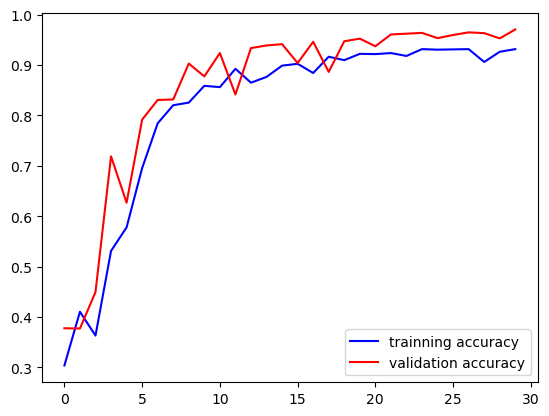

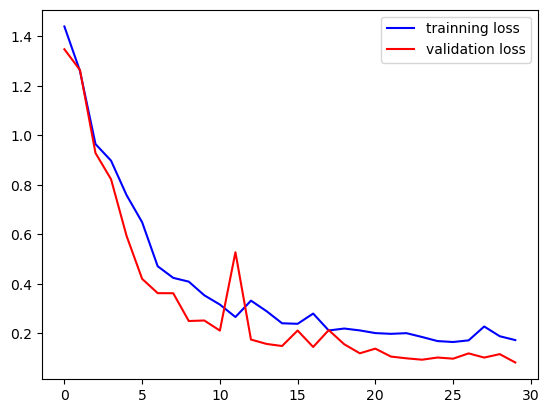

In [59]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [60]:
predict = model.predict(x_test)
predicted_classes = np.argmax(predict, axis = 1)

y_true = np.argmax(y_test, axis = 1)

61/61 [==============================] - 25s 402ms/step


<Figure size 800x600 with 0 Axes>

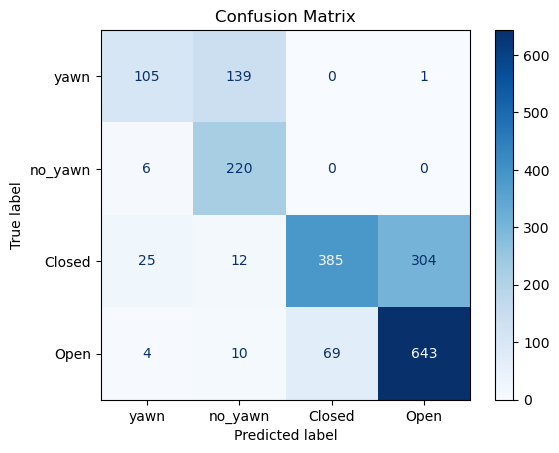

In [61]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_true, predicted_classes)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
metrics.ConfusionMatrixDisplay(cm, display_labels=["yawn", "no_yawn", "Closed", "Open"]).plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [62]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes, target_names=labels_new, zero_division=1))

              precision    recall  f1-score   support

        yawn       0.75      0.43      0.55       245
     no_yawn       0.58      0.97      0.72       226
      Closed       0.85      0.53      0.65       726
        Open       0.68      0.89      0.77       726

    accuracy                           0.70      1923
   macro avg       0.71      0.70      0.67      1923
weighted avg       0.74      0.70      0.69      1923



In [63]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

def load_images(dir_path, face_cas="haar_cascade_files/haarcascade_frontalface_default.xml"):
    IMG_SIZE = 145
    data = []
    for img in os.listdir(dir_path):
        img_array = cv2.imread(os.path.join(dir_path, img), cv2.IMREAD_COLOR)
        img_array = img_array / 255
        resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
        data.append( resized_array)
    return data

In [64]:
x_predict = load_images(pred_dir)
x_predict = np.array(x_predict)
x_predict = x_predict.reshape(-1, 145, 145, 3)
len(x_predict)

2467

In [65]:
y_predict = model.predict(x_predict)

78/78 [==============================] - 31s 394ms/step


In [66]:
def get_label(n):
    labels = {"yawn":0, "no_yawn":1, "Closed":2, "Open":3}
    for x,y in labels.items():
        if n == y:
            return x

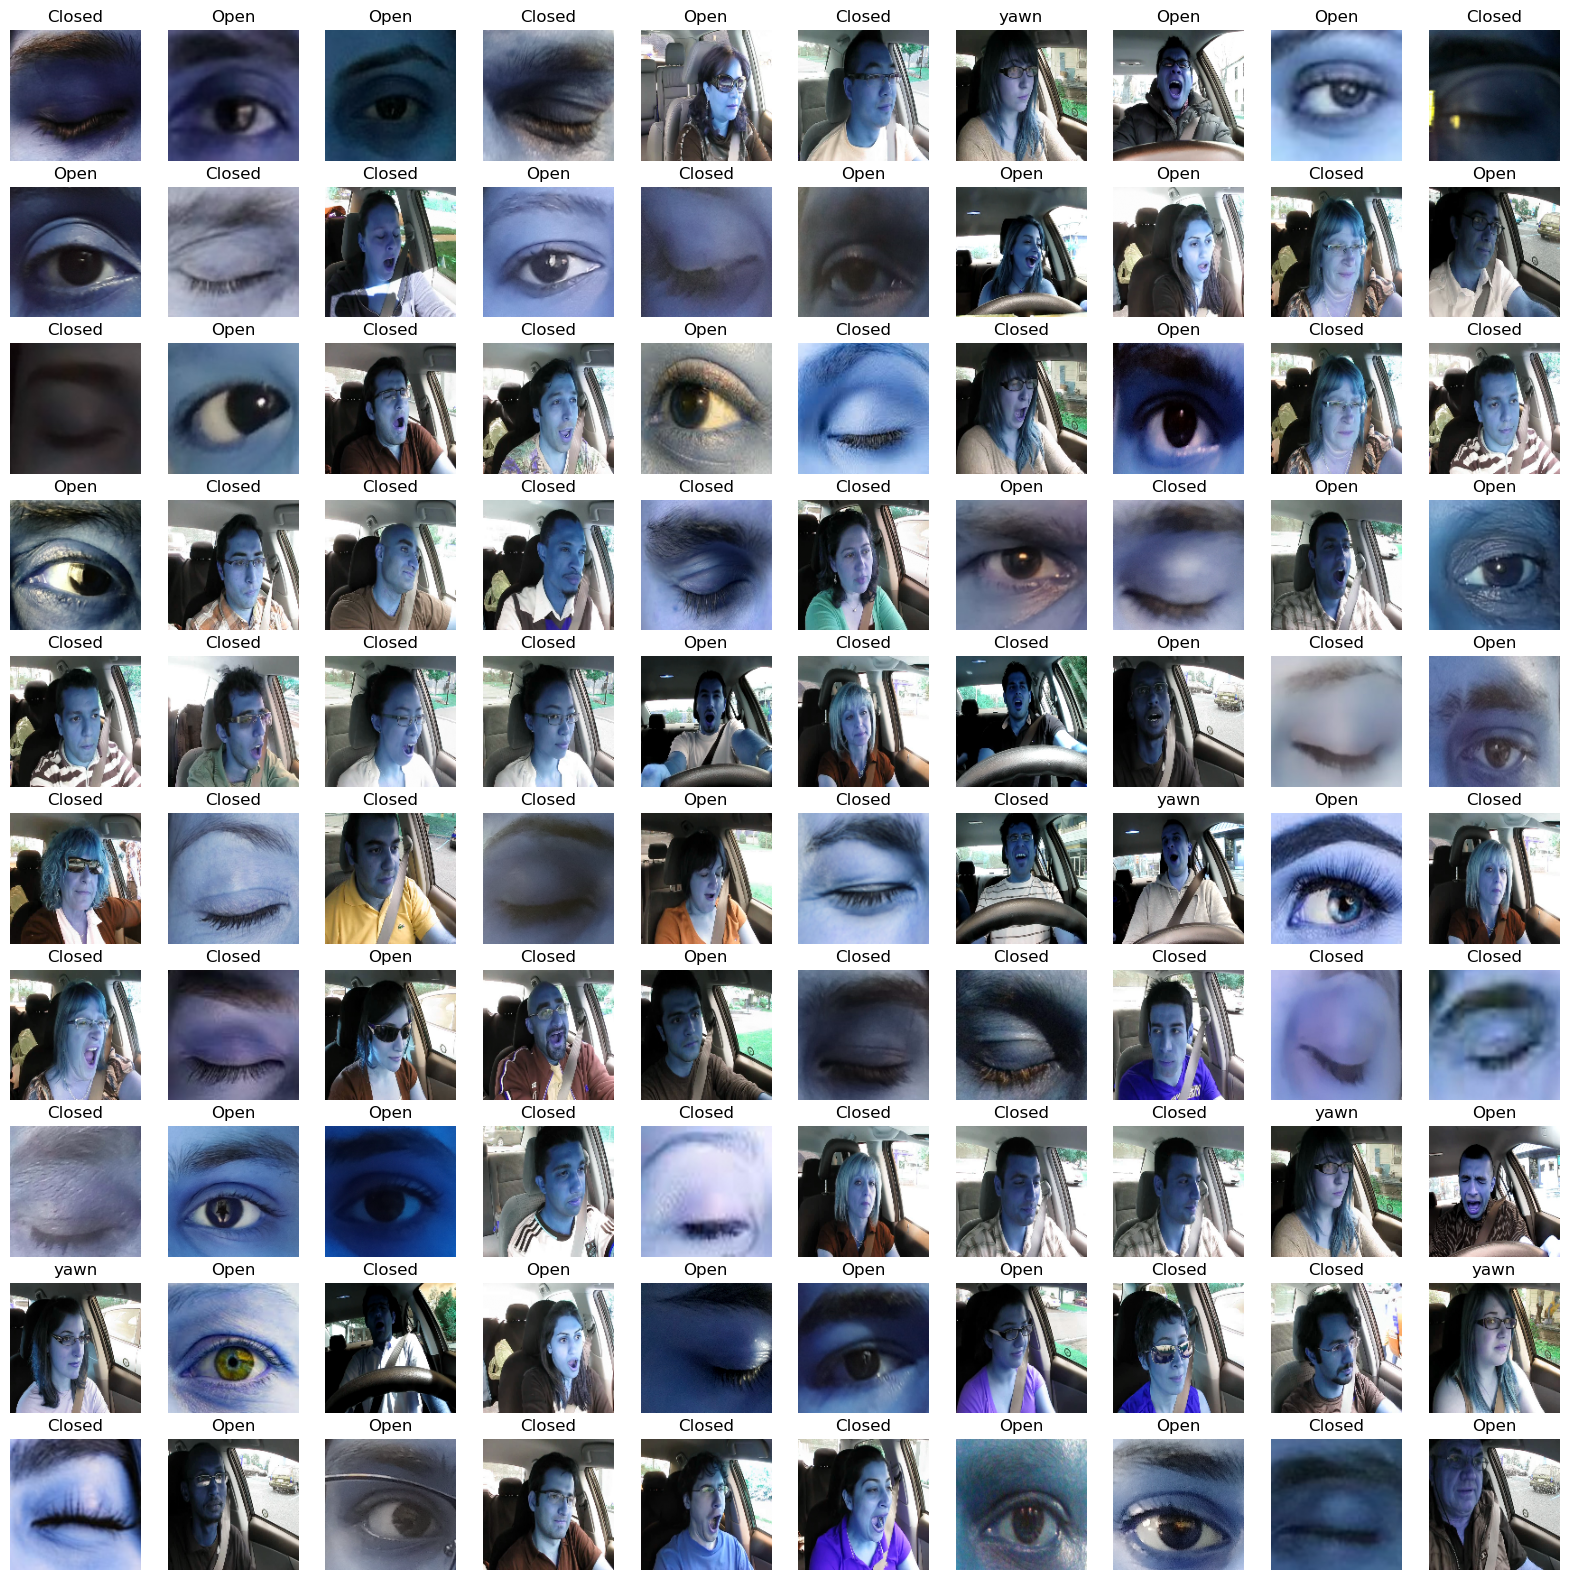

In [67]:
plt.figure(figsize = (20,20))
for n, i in enumerate(list(np.random.randint(0,len(x_predict),100))):
    plt.subplot(10,10, n+1)
    plt.imshow(x_predict[i])
    plt.axis('off')
    plt.title(get_label(np.argmax(y_predict[i])))

In [68]:
model.save("Driver_Drowsiness_Detection_System.h5")

C:\Users\Khalil\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
